# Modeling

## Introduction

In this notebook, we finally get to explore some machine learning models in attempt to predict baseball pitch types. We have wrangled, explored, and processed Statcast data resulting in 3 datasets available for modeling:

- no_pitchers - All pitches without pitcher reference
- pitchers - All pitches with reference to top 5 pitchers based on pitch count
- first_pitch - Only the first pitch in each at-bat without pitcher reference

From here, we can explore modeling various scenarios with the data above. We'll begin by setting a baseline from predicting all pitches as the most common pitch type, FF. Our modeling efforts will include scaling the data, creating a train/test split, and evaluating performance metrics. We will also complete tuning of some hyperparameters relevant to each model. 

## Imports and Data Load

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

In [115]:
no_pitchers = pd.read_csv('no_pitchers.csv')
pitchers = pd.read_csv('pitchers.csv')
first_pitch = pd.read_csv('first_pitch.csv')

Given that we have split the data we've been working with, let's check to make sure we have enough observations (pitches) within each dataset.

In [116]:
print(no_pitchers.shape)
print(pitchers.shape)
print(first_pitch.shape)

(110301, 26)
(3114, 31)
(28166, 26)


We have plenty of pitches to work with. The 5 extra features in the 'pitchers' dataset are the 5 pitchers we kept and encoded.

## Train/Test Split

We begin with our first_pitch dataset containing only the first pitch of each at-bat in a given game.

In [117]:
first_pitch.head().T

,0,1,2,3,4
pitch_type,SL,FF,FF,SL,FF
balls,0,0,0,0,0
strikes,0,0,0,0,0
on_3b,0,0,0,0,0
on_2b,1,1,1,1,0
on_1b,1,0,0,0,1
outs_when_up,2,2,2,1,0
inning,9,9,9,9,9
at_bat_number,77,76,75,74,73
pitch_number,1,1,1,1,1


Let's define X and y, then check the partition sizes if we use a 70/30 train/test split.

In [118]:
X = first_pitch.drop(columns='pitch_type')
y = first_pitch['pitch_type']

In [119]:
len(first_pitch) * .7, len(first_pitch) * .3

(19716.199999999997, 8449.8)

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [121]:
X_train.shape, X_test.shape

((19716, 25), (8450, 25))

In [122]:
y_train.shape, y_test.shape

((19716,), (8450,))

The shape of our train/test split aligns with expectations for a 70/30 train/test split. Let's check to make sure all or our features are of numeric type.

In [123]:
X_train.dtypes

balls                                   int64
strikes                                 int64
on_3b                                   int64
on_2b                                   int64
on_1b                                   int64
outs_when_up                            int64
inning                                  int64
at_bat_number                           int64
pitch_number                            int64
home_score                              int64
away_score                              int64
bat_score                               int64
fld_score                               int64
stand_L                                 int64
stand_R                                 int64
p_throws_L                              int64
p_throws_R                              int64
inning_topbot_Bot                       int64
inning_topbot_Top                       int64
if_fielding_alignment_Infield shift     int64
if_fielding_alignment_Standard          int64
if_fielding_alignment_Strategic   

In [124]:
X_test.dtypes

balls                                   int64
strikes                                 int64
on_3b                                   int64
on_2b                                   int64
on_1b                                   int64
outs_when_up                            int64
inning                                  int64
at_bat_number                           int64
pitch_number                            int64
home_score                              int64
away_score                              int64
bat_score                               int64
fld_score                               int64
stand_L                                 int64
stand_R                                 int64
p_throws_L                              int64
p_throws_R                              int64
inning_topbot_Bot                       int64
inning_topbot_Top                       int64
if_fielding_alignment_Infield shift     int64
if_fielding_alignment_Standard          int64
if_fielding_alignment_Strategic   

## Baseline
We begin with our baseline of predicting the most frequent pitch type (FF) for all pitches. Sklearn's DummyClassifier allows us to easily accomplish this.

In [125]:
dumb_class = DummyClassifier(strategy='constant', constant='FF')
dumb_class.fit(X_train, y_train)
dumb_class.constant

'FF'

In [126]:
y_train_pred = dumb_class.predict(X_train)
print(y_train_pred[:5])

['FF' 'FF' 'FF' 'FF' 'FF']


In [127]:
print(classification_report(y_train, y_train_pred, zero_division=0))

              precision    recall  f1-score   support

          CH       0.00      0.00      0.00      1506
          CU       0.00      0.00      0.00      2009
          EP       0.00      0.00      0.00         1
          FC       0.00      0.00      0.00      1215
          FF       0.37      1.00      0.54      7383
          FS       0.00      0.00      0.00       166
          FT       0.00      0.00      0.00      1977
          KC       0.00      0.00      0.00       490
          KN       0.00      0.00      0.00        11
          SI       0.00      0.00      0.00      1750
          SL       0.00      0.00      0.00      3208

    accuracy                           0.37     19716
   macro avg       0.03      0.09      0.05     19716
weighted avg       0.14      0.37      0.20     19716



The classification report confirms our dummy classification model predicted only FF as it's the only class with non-zero values. The report also confirms FF is the most frequent pitch type as its support value is the largest. Both the precision and recall for FF are as expected given the accuracy of our positives for FF, precision, should be equal to the ratio of FF to all, and our recall, or the percent of positives we predicted accurately, should be 100% or 1.0.

Due to the nature of the unbalanced classes in our multivariate classification problem, we will be focused on the macro avg f1-score for performance measurement of our models. Let's move on to our first real model using sklearn's DecisionTreeClassifier.

## Decision Tree

In [128]:
from sklearn import tree, metrics

In [129]:
tree_model = tree.DecisionTreeClassifier(criterion="gini", random_state = 42)
tree_model.fit(X_train, y_train) 
y_pred = tree_model.predict(X_test)
y_pred = pd.Series(y_pred)

tree_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

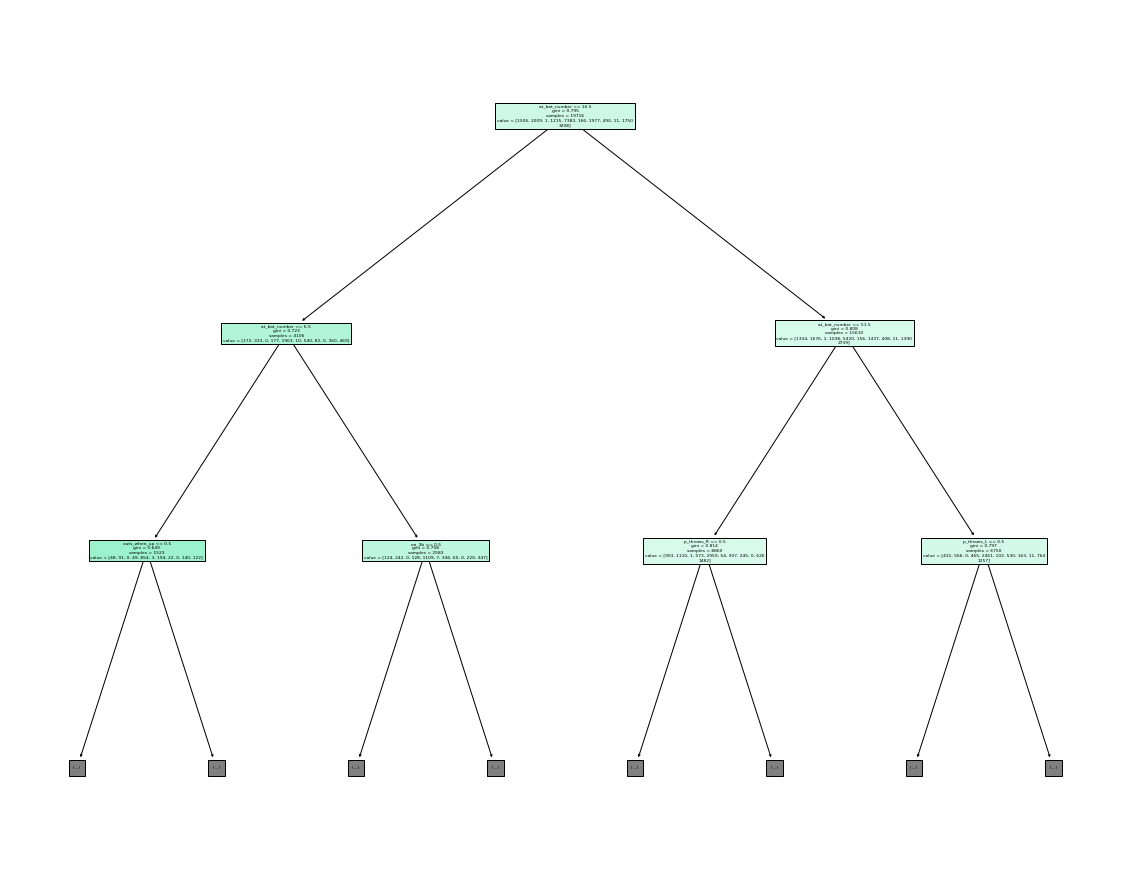

In [130]:
plt.figure(figsize=(20,16))
tree.plot_tree(tree_model, max_depth=2, feature_names=X_train.columns, filled=True);

The accuracy is worse, but that's because of the unbalanced classes. The macro average f1-score has improved from 0.05 to 0.17 so we've improved our ability to predict pitch type over guessing FF for all. 

In [131]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

          CH       0.12      0.15      0.13       615
          CU       0.14      0.14      0.14       871
          EP       0.00      0.00      0.00         1
          FC       0.12      0.13      0.12       509
          FF       0.43      0.43      0.43      3287
          FS       0.05      0.05      0.05        63
          FT       0.13      0.13      0.13       809
          KC       0.08      0.09      0.08       199
          KN       0.33      0.67      0.44         3
          SI       0.16      0.14      0.15       711
          SL       0.23      0.21      0.22      1382

    accuracy                           0.26      8450
   macro avg       0.16      0.19      0.17      8450
weighted avg       0.26      0.26      0.26      8450



## Random Forest
Let's see if an ensemble method for decision trees can help improve our accuracy. We will use a RandomForestClassifier within a pipeline that is also scaling the data, in addition to cross-validation and grid search for hyperparameter tuning.

In [132]:
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=42))

In [133]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

C:\Users\Louie\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [134]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.31440162, 0.30332234, 0.3061121 , 0.31397413, 0.30535126])

In [138]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.3086322900521066, 0.004628878074447674)

In [139]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestclassifier__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
}
grid_params

{'randomforestclassifier__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(copy=True, with_mean=True, with_std=True),
  None]}

In [144]:
#RandomizedSearchCV?

In [141]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)

C:\Users\Louie\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                   

In [142]:
rf_grid_cv.best_params_

{'randomforestclassifier__n_estimators': 297,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [145]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

C:\Users\Louie\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


array([0.32023327, 0.30636571, 0.31143799, 0.32234339, 0.31321329])

In [146]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.31471873024267205, 0.005854026184189302)

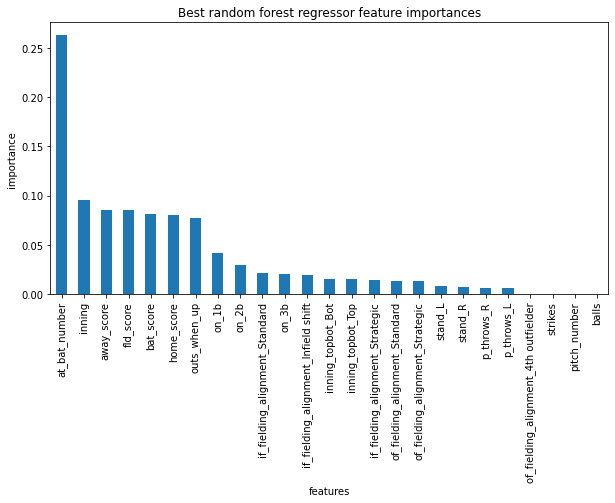

In [148]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestclassifier.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [73]:
pipe.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=-1,
                                        oob_score=False, random_state=42,
                                        verbose=1, warm_start=False))],
         verbose=False

In [74]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [78]:
print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

          CH       0.18      0.15      0.16       615
          CU       0.16      0.11      0.13       871
          EP       0.00      0.00      0.00         1
          FC       0.15      0.08      0.10       509
          FF       0.42      0.61      0.50      3287
          FS       0.13      0.05      0.07        63
          FT       0.15      0.10      0.12       809
          KC       0.05      0.03      0.03       199
          KN       1.00      0.67      0.80         3
          SI       0.19      0.11      0.14       711
          SL       0.24      0.21      0.22      1382

    accuracy                           0.32      8450
   macro avg       0.24      0.19      0.21      8450
weighted avg       0.27      0.32      0.29      8450



## Support Vector Machine

In [103]:
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [104]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

          CH       0.00      0.00      0.00       615
          CU       0.00      0.00      0.00       871
          EP       0.00      0.00      0.00         1
          FC       0.00      0.00      0.00       509
          FF       0.39      1.00      0.56      3287
          FS       0.00      0.00      0.00        63
          FT       0.00      0.00      0.00       809
          KC       0.00      0.00      0.00       199
          KN       0.00      0.00      0.00         3
          SI       0.00      0.00      0.00       711
          SL       0.00      0.00      0.00      1382

    accuracy                           0.39      8450
   macro avg       0.04      0.09      0.05      8450
weighted avg       0.15      0.39      0.22      8450

